In [1]:
feature_names = [
    "player_rating_home_player_1",
    "player_rating_home_player_2",
    "player_rating_home_player_3",
    "player_rating_home_player_4",
    "player_rating_home_player_5",
    "player_rating_home_player_6",
    "player_rating_home_player_7",
    "player_rating_home_player_8",
    "player_rating_home_player_9",
    "player_rating_home_player_10",
    "player_rating_home_player_11",
    "player_rating_away_player_1",
    "player_rating_away_player_2",
    "player_rating_away_player_3",
    "player_rating_away_player_4",
    "player_rating_away_player_5",
    "player_rating_away_player_6",
    "player_rating_away_player_7",
    "player_rating_away_player_8",
    "player_rating_away_player_9",
    "player_rating_away_player_10",
    "player_rating_away_player_11",
    "ewm_home_team_goals",
    "ewm_away_team_goals",
    "ewm_home_team_goals_conceded",
    "ewm_away_team_goals_conceded",
    "points_home",
    "points_away",
    "home_weighted_wins",
    "away_weighted_wins",
    "avg_home_team_rating",
    "avg_away_team_rating",
    "home_streak_wins",
    "away_streak_wins",
    "ewm_shoton_home",
    "ewm_shoton_away",
    "ewm_possession_home",
    "ewm_possession_away",
    "avg_home_rating_attack",
    "avg_away_rating_attack",
    "avg_away_rating_defence",
    "avg_home_rating_defence",
    "average_rating_home",
    "average_rating_away",
    "num_top_players_home",
    "num_top_players_away",
    "ewm_home_team_goals_conceded_x_ewm_shoton_home",
    "attacking_strength_home",
    "attacking_strength_away",
    "attacking_strength_diff"
]

In [2]:
import posixpath
import boto3
from smdebug.trials import create_trial

sm_client = boto3.client('sagemaker')

def get_latest_training_job():
    training_jobs = sm_client.list_training_jobs(SortBy='CreationTime', SortOrder='Descending')['TrainingJobSummaries']
    if training_jobs:
        latest_job_name = training_jobs[0]['TrainingJobName']
        return latest_job_name
    else:
        raise Exception("No training jobs found")

def get_debugger_artifacts_path(training_job_name):
    response = sm_client.describe_training_job(TrainingJobName=training_job_name)
    if 'DebugHookConfig' in response and 'S3OutputPath' in response['DebugHookConfig']:
        s3_output_path = response['DebugHookConfig']['S3OutputPath']
        if not s3_output_path.endswith('/'):
            s3_output_path += '/'
        return s3_output_path + training_job_name + "/"
    else:
        raise Exception("Debugger artifacts path not found for the training job")

latest_training_job_name = get_latest_training_job()
print(f"Latest Training Job Name: {latest_training_job_name}")

bucket = 'football-bucket'
key = posixpath.join('train_analyse', latest_training_job_name, 'debug-output', '')

debugger_artifacts_path = f's3://{bucket}/{key}'
print(f"Debugger Artifacts Path: {debugger_artifacts_path}")

[2024-11-30 14:34:44.281 DESKTOP-Q66KT1Q:30472 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
Latest Training Job Name: xgb-clf-training-container-01u61k8k637z-yTikGcPPRE
Debugger Artifacts Path: s3://football-bucket/train_analyse/xgb-clf-training-container-01u61k8k637z-yTikGcPPRE/debug-output/


In [6]:
trial = create_trial(debugger_artifacts_path)
trial

[2024-11-30 14:36:51.408 DESKTOP-Q66KT1Q:30472 INFO s3_trial.py:43] Loading trial  at path s3://football-bucket/train_analyse/xgb-clf-training-container-01u61k8k637z-yTikGcPPRE/debug-output/
[2024-11-30 14:36:52.464 DESKTOP-Q66KT1Q:30472 INFO trial.py:197] Training has ended, will refresh one final time in 1 sec.
[2024-11-30 14:36:53.516 DESKTOP-Q66KT1Q:30472 INFO trial.py:210] Loaded all steps


<smdebug.trials.s3_trial.S3Trial object at 0x219ffa17f20>:(
    name=,
    path=s3://football-bucket/train_analyse/xgb-clf-training-container-01u61k8k637z-yTikGcPPRE/debug-output/,
    steps=[0, 10, 20, 30, 40],
    collections=['average_shap', 'trees', 'default', 'all', 'hyperparameters', 'full_shap', 'labels', 'predictions', 'feature_importance', 'metrics', 'losses'],
    tensor_names=['average_shap/f0', 'average_shap/f1', 'average_shap/f10', 'average_shap/f11', 'average_shap/f12', 'average_shap/f13', 'average_shap/f14', 'average_shap/f15', 'average_shap/f16', 'average_shap/f17', 'average_shap/f18', 'average_shap/f19', 'average_shap/f2', 'average_shap/f20', 'average_shap/f21', 'average_shap/f22', 'average_shap/f23', 'average_shap/f24', 'average_shap/f25', 'average_shap/f26', 'average_shap/f27', 'average_shap/f28', 'average_shap/f29', 'average_shap/f3', 'average_shap/f30', 'average_shap/f31', 'average_shap/f32', 'average_shap/f33', 'average_shap/f34', 'average_shap/f35', 'average_shap

In [7]:
from itertools import islice
import matplotlib.pyplot as plt
import re

MAX_PLOTS = 35


def get_data(trial, tname):
    """
    For the given tensor name, walks though all the iterations
    for which you have data and fetches the values.
    Returns the set of steps and the values.
    """
    tensor = trial.tensor(tname)
    steps = tensor.steps()
    vals = [tensor.value(s) for s in steps]
    return steps, vals


def match_tensor_name_with_feature_name(tensor_name, feature_names=feature_names):
    feature_tag = tensor_name.split("/")
    for ifeat, feature_name in enumerate(feature_names):
        if feature_tag[-1] == "f{}".format(str(ifeat)):
            return feature_name
    return tensor_name


def plot_collection(trial, collection_name, regex=".*", figsize=(8, 6)):
    """
    Takes a `trial` and a collection name, and
    plots all tensors that match the given regex.
    """
    fig, ax = plt.subplots(figsize=figsize)
    tensors = trial.collection(collection_name).tensor_names
    matched_tensors = [t for t in tensors if re.match(regex, t)]
    for tensor_name in islice(matched_tensors, MAX_PLOTS):
        steps, data = get_data(trial, tensor_name)
        ax.plot(steps, data, label=match_tensor_name_with_feature_name(tensor_name))

    ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlabel("Iteration")

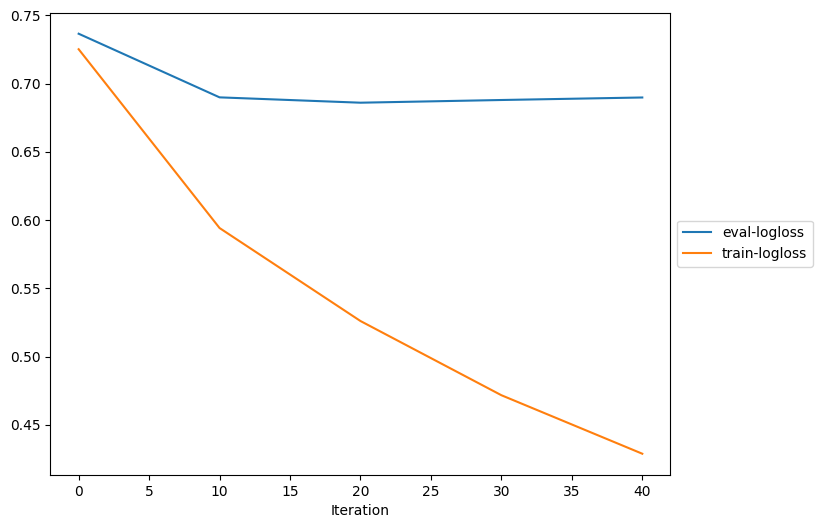

In [11]:
plot_collection(trial, 'metrics')

In [9]:
def plot_feature_importance(trial, importance_type="weight"):
    SUPPORTED_IMPORTANCE_TYPES = [
        "weight",
        "gain",
        "cover",
        "total_gain",
        "total_cover",
    ]
    if importance_type not in SUPPORTED_IMPORTANCE_TYPES:
        raise ValueError(f"{importance_type} is not one of the supported importance types.")
    plot_collection(trial, "feature_importance", regex=f"feature_importance/{importance_type}/.*")

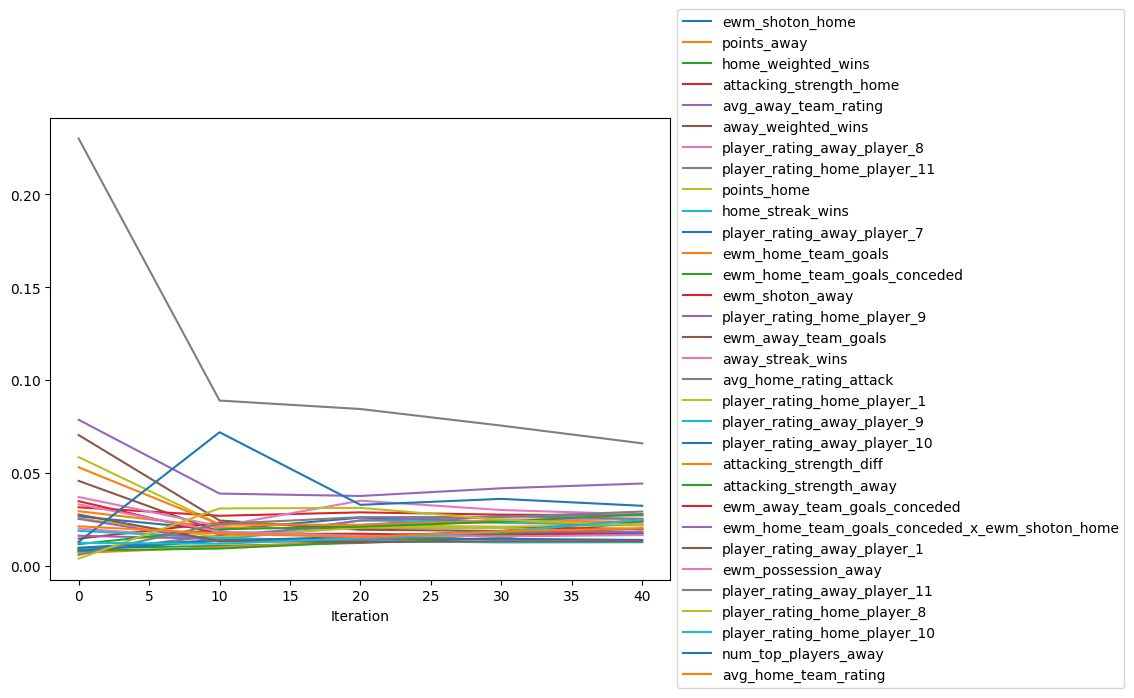

In [10]:
plot_feature_importance(trial, importance_type="cover")

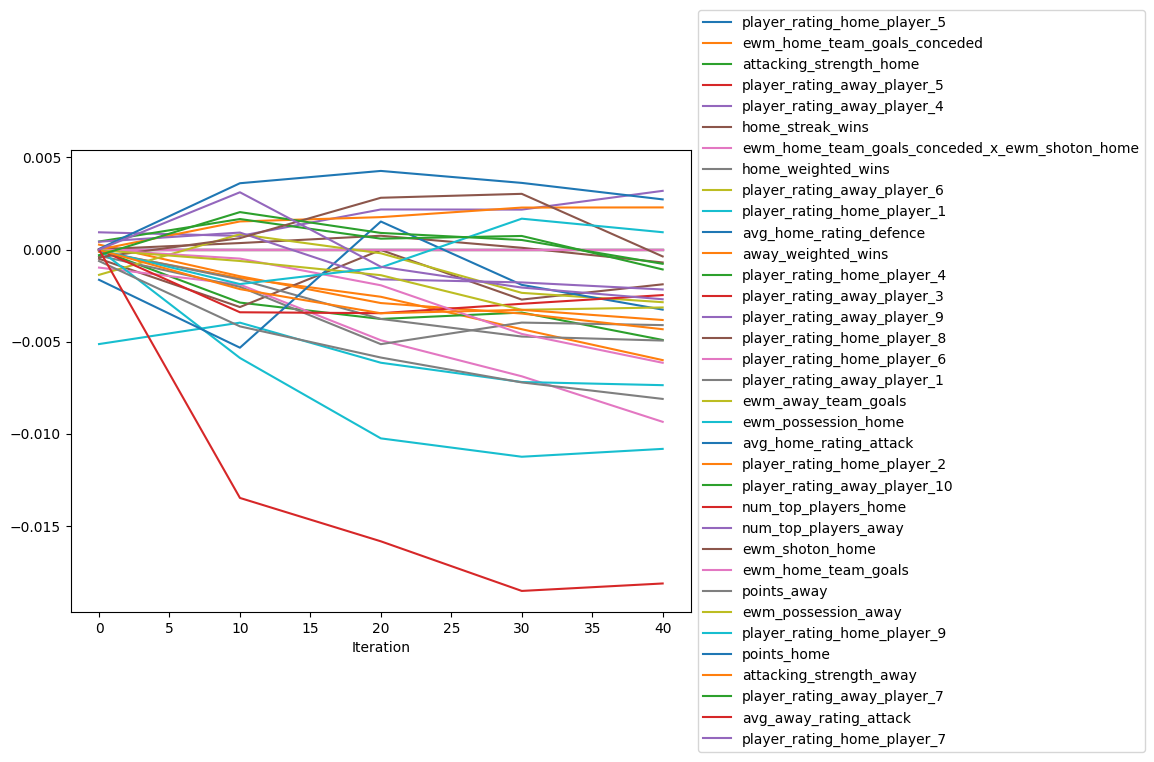

In [12]:
plot_collection(trial, "average_shap")

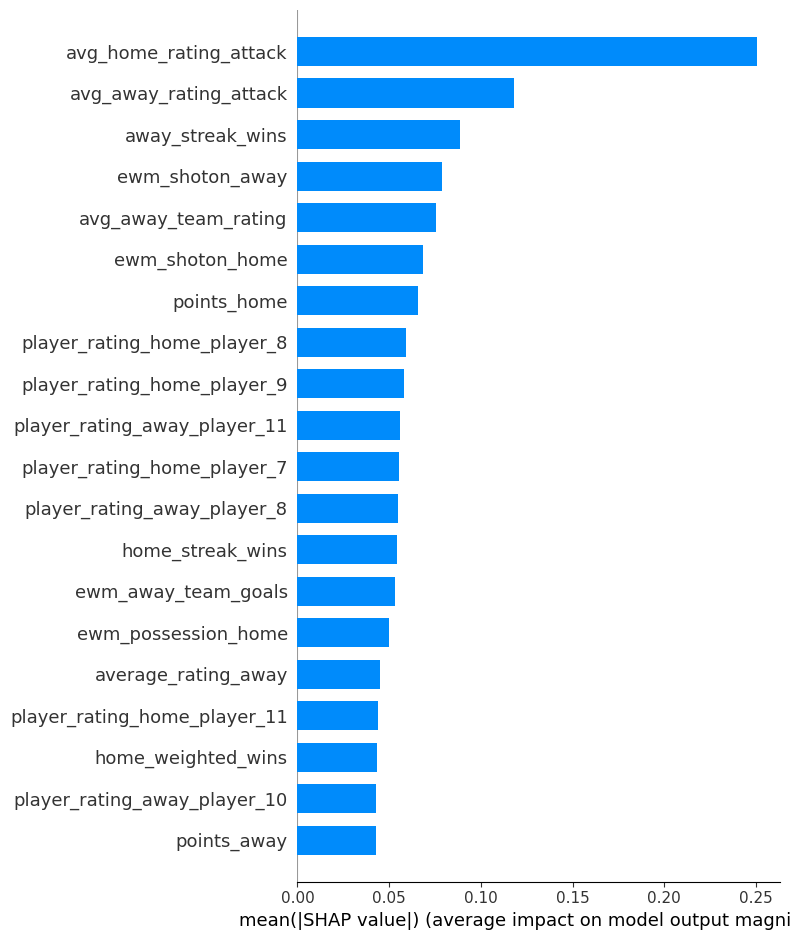

0.621924

In [13]:
import shap

shap_values = trial.tensor("full_shap/f0").value(trial.last_complete_step)
shap_no_base = shap_values[:, :-1]
shap_base_value = shap_values[0, -1]
shap.summary_plot(shap_no_base, plot_type="bar", feature_names=feature_names)

shap_base_value

In [25]:
import boto3
import os
import pandas as pd

%load_ext dotenv
%dotenv

pipeline_name = os.environ["PIPELINE_NAME"]

print(f"Pipeline Name: {pipeline_name}")

pipeline_executions = sm_client.list_pipeline_executions(
    PipelineName=pipeline_name,
    SortBy='CreationTime',
    SortOrder='Descending',
    MaxResults=1
)

if not pipeline_executions['PipelineExecutionSummaries']:
    raise ValueError('No pipeline executions found for the specified pipeline.')

latest_execution = pipeline_executions['PipelineExecutionSummaries'][0]
execution_arn = latest_execution['PipelineExecutionArn']

execution_steps = sm_client.list_pipeline_execution_steps(
    PipelineExecutionArn=execution_arn
)

train_csv_uri = None

for step in execution_steps['PipelineExecutionSteps']:
    if step['StepName'] == 'split-and-transform-data':
        processing_job_arn = step['Metadata']['ProcessingJob']['Arn']
        processing_job_name = processing_job_arn.split('/')[-1]
        
        processing_job_desc = sm_client.describe_processing_job(
            ProcessingJobName=processing_job_name
        )
        
        outputs = processing_job_desc['ProcessingOutputConfig']['Outputs']
        for output in outputs:
            if output['OutputName'] == 'train':
                s3_uri = output['S3Output']['S3Uri']
                train_csv_uri = f"{s3_uri}/train.csv"
                print('train.csv S3 URI:', train_csv_uri)
        break
else:
    raise ValueError('The split-and-transform-data step was not found in the latest execution.')


if train_csv_uri is None:
    raise ValueError('train.csv URI could not be found.')

X_train_display = pd.read_csv(train_csv_uri)
X_train_display.drop(labels=['result_match'], axis=1, inplace=True)

print(X_train_display.head(1))

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv
Pipeline Name: football-pipeline
train.csv S3 URI: s3://football-bucket/football-pipeline/tzq5r1ms7b6f/split-and-transform-data/output/train/train.csv
   player_rating_home_player_1  player_rating_home_player_2  \
0                         70.0                         70.0   
1                         73.0                         73.0   
2                         74.0                         74.0   
3                         86.0                         86.0   
4                         68.0                         68.0   

   player_rating_home_player_3  player_rating_home_player_4  \
0                         70.0                         70.0   
1                         73.0                         73.0   
2                         74.0                         74.0   
3                         86.0                         86.0   
4                         68.0                         68.0   

   player_r

In [41]:
import numpy as np

os.mkdir('plots')

N_ROWS = shap_no_base.shape[0]
N_SAMPLES = min(100, N_ROWS)
sampled_indices = np.random.randint(N_ROWS, size=N_SAMPLES)

force_plot = shap.force_plot(
    shap_base_value,
    shap_no_base[sampled_indices, :],
    X_train_display.iloc[sampled_indices, :],
    link="logit"
)

shap.save_html('plots/force_plot.html', force_plot)

In [42]:
from scipy import stats

N_OUTLIERS = 3

shap_sum = np.sum(shap_no_base, axis=1)
z_scores = stats.zscore(shap_sum)
outlier_indices = (np.argpartition(z_scores, -N_OUTLIERS)[-N_OUTLIERS:]).tolist()
outlier_indices += (np.argpartition(z_scores, N_OUTLIERS)[:N_OUTLIERS]).tolist()

shap.initjs()

for fig_index, outlier_index in enumerate(outlier_indices, start=1):
    force_plot = shap.force_plot(
        shap_base_value,
        shap_no_base[outlier_index, :],
        X_train_display.iloc[outlier_index, :],
        matplotlib=False,
        link="logit",
    )

    shap.save_html(f'plots/force_plot_{fig_index}.html', force_plot)
    
    print(f"Saved force plot {fig_index} for index {outlier_index} to force_plot_{fig_index}.html")


Saved force plot 1 for index 3191 to force_plot_1.html
Saved force plot 2 for index 3088 to force_plot_2.html
Saved force plot 3 for index 2391 to force_plot_3.html
Saved force plot 4 for index 690 to force_plot_4.html
Saved force plot 5 for index 4202 to force_plot_5.html
Saved force plot 6 for index 477 to force_plot_6.html
